In [1]:
# Author: Leonie Küchenhoff
# Date: Jan 11th, 2022
# Script to compare Casß expression across samples
# Prior to script: run cas_expr_start.sh

In [19]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import os
from config import basedir, outdir
import numpy as np
import seaborn as sns

In [ ]:
# directory settings
os.chdir(basedir)
outdir = str(outdir + '/cas_expr/')
print('This base directory will be used:\n', basedir)
os.chdir(basedir)

In [21]:
# sample names
names = ['028_pbs_R', '029_pbs_R', '032_pbs_R','033_nrch_R', '030_nrch_R', '036_nrch_R', 
            '011_pbs', '012_nrch', '013_nrch', '014_nrch', '279_spry', '321_pbs', '333_pbs', '450_spry', '283_spry']
# treatment in same order as sample names
based_editor = ['pbs', 'pbs', 'pbs', '8e-NRCH', '8e-NRCH', '8e-NRCH',
            'pbs', '8e-NRCH', '8e-NRCH','8e-NRCH', 'max-SpRY', 'pbs', 'pbs', 'max-SpRY', 'max-SpRY']
mutation = ['R636Q' if i[-1] == 'R' else 'P635L' for i in names]
condition = [i+' - '+j for i,j in zip(based_editor, mutation)]
chromosomes = ['chr1','chr2','chr3','chr4','chr5','chr6', 'chr7', 'chr8', 'chr9','chr10',
'chr11','chr12','chr13','chr14','chr15','chr16', 'chr17', 'chr18', 'chr19']


In [22]:
def read_and_filter(path):
    '''
    function to read coverage file and return average RPKM value
    '''
    file = pd.read_csv(path, header = None, sep = '\t', names = ['chr', 'start', 'stop', 'CPM'])
    mean_cov = (file['CPM'] * (file['stop'] - file['start'])).sum() / 1716
    return mean_cov

In [23]:
heart_expr = np.zeros(15)
liver_expr = np.zeros(15)
for count,i in enumerate(names):
    liver_expr[count] = read_and_filter(f'cas_expr/L{i}.bed')
    heart_expr[count] = read_and_filter(f'cas_expr/H{i}.bed')

In [24]:
save = pd.DataFrame(data = {'sample':names,'heart':heart_expr, 'liver':liver_expr})
save['condition'] = condition
save['base_editor'] = based_editor
save['mutation'] = mutation
reformat = save.melt(id_vars = ['sample','condition', 'base_editor', 'mutation']).rename(columns = {'variable':'tissue', 'value': 'mean_RPKM'})

In [37]:
plt.rcParams.update({'font.size':22, 'text.usetex': False,
"svg.fonttype": 'none'})

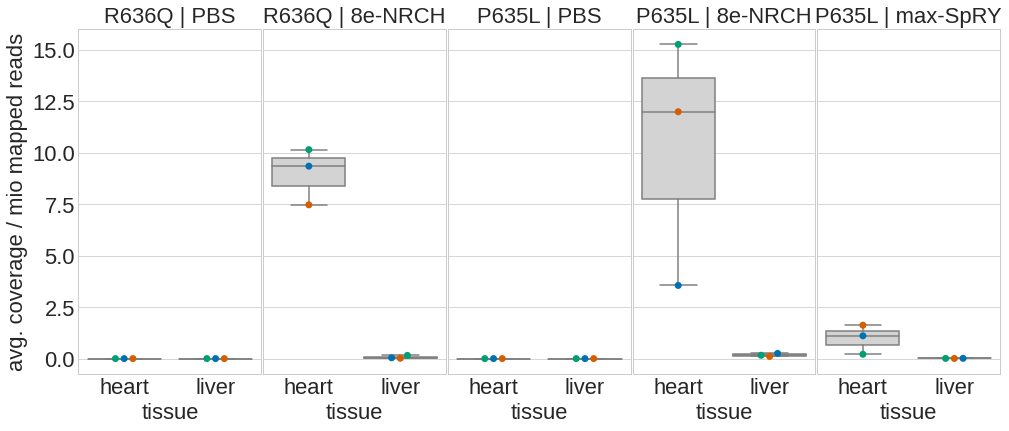

In [38]:
fig, axs = plt.subplots(1,5, figsize = (16,6), sharey = True)
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')

editor = ['pbs','8e-NRCH','pbs', '8e-NRCH', 'max-SpRY']
mutation = ['R636Q','R636Q','P635L','P635L','P635L']
for count, e in enumerate(editor):
    m = mutation[count]
    data = reformat[(reformat['base_editor'] == e) & (reformat['mutation'] == m)]
    sns.boxplot(x = 'tissue', y = 'mean_RPKM', data = data, color = 'lightgrey', ax = axs[count])
    sns.swarmplot(x = 'tissue', y = 'mean_RPKM', data = data, hue = 'sample', size = 7, ax = axs[count])

for ax in axs:
    ax.set_ylabel('')
    ax.set_xlabel('tissue')
    ax.get_legend().remove()

axs[1].set_title('R636Q | 8e-NRCH', size = 22)
axs[0].set_title('R636Q | PBS', size = 22)
axs[3].set_title('P635L | 8e-NRCH', size = 22)
axs[4].set_title('P635L | max-SpRY', size = 22)
axs[2].set_title('P635L | PBS', size = 22)
axs[0].set_ylabel(f'avg. coverage / mio mapped reads', size = 22)
fig.tight_layout()

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.01,
                    hspace=0.4)

plt.show()
fig.savefig(f'{outdir}/mean_RPKM.pdf', bbox_inches = 'tight')
fig.savefig(f'{outdir}/mean_RPKM.svg', bbox_inches = 'tight')
reformat.to_csv(f'{outdir}/mean_RPKM.txt', index = False)
